# Analyses of thyroid AHP model

## Imports first

In [299]:
# Pandas has DataFrames and Series, very useful things
import pandas as pd
# numpy has lots of useful things in it
import numpy as np
# lastly import our ahptree python code.  If you haven't already installed the pyanp library do
# pip install pyanp
# to get it
from pyanp import ahptree
import matplotlib.pyplot as plt
import re
import random

In [4]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,6)

## Load the model

In [6]:
excel_file = 'thyroid_model.xlsx'
ahp = ahptree.ahptree_fromdf(excel_file)

# Try all possible votes combinations, see which wins

## We need a class to store comparisons

This class is used to store a full set of comparisons for an AHP model in a way that we can increment to the "next vote".  In other words, when we increment this class, it changes on pairwise vote to the next value in the variable `self.POSSIBLE_VOTES` in `ComparisonSet`.

We will use it to iterate over all possible pairwise comparisons and see the rankings that happen

In [312]:
class ComparisonSet:
    def __init__(self, user, ahp, cmps):
        self.user=user
        self.BETTER=2
        self.MUCH_BETTER=5
        self.POSSIBLE_VOTES=[1/MUCH_BETTER, 1/BETTER, 1, BETTER, MUCH_BETTER]
        self.votes = np.zeros([len(cmps)], dtype=int)
        self.numbCmps=len(self.POSSIBLE_VOTES)
        self.compares = cmps
        self.nodes = ahp.nodenames()
        self.ahp=ahp
    def incr(self):
        # increment the first value
        self.votes[0]+=1
        currentPos=0
        while self.votes[currentPos] >= self.numbCmps:
            # We need to "carry the 1" over
            self.votes[currentPos] = 0
            if currentPos < (len(self.votes) -1):
                # We have a place to carry the one to
                currentPos+=1
                self.votes[currentPos]+=1
            else:
                # We reached the end, everythign is 0 again, return false
                return False
        # If we made it here, we succeeded
        self.vote()
        return True
    def random(self):
        '''
        Randomly updates the votes here and sends to the ahp model
        '''
        for i in range(len(self.votes)):
            self.votes[i] = random.randrange(len(self.POSSIBLE_VOTES))
        self.vote()
        
    def monte_carlo(self, nTrials=10000):
        '''
        Performs a monte carlo analysis, randomly voting and getting the
        order of the alternatives.  Returns a pd.Series whose keys are the
        alt names in order and value is the number of times that ranking 
        occured
        '''
        rankCounts = pd.Series({})
        for i in range(nTrials):
            self.random()
            p=self.ahp.priority()
            # Get the alt names in rank sort order from best to worst
            rankKey=sortedIndex(p)
            # Check to see if this is the first time seeing that ordering
            if rankKey not in rankCounts:
                # It was the first time seeing that ordering, initialize
                rankCounts[rankKey]=0
            # Increment the count for this ranking
            rankCounts[rankKey]+=1
        return rankCounts
        
    def vote(self):
        '''
        Inserts the votes into the model
        '''
        for cmp,voteIndex in zip(self.compares,self.votes):
            wrt = self.nodes[cmp[0]]
            node1 = self.nodes[cmp[1]]
            node2 = self.nodes[cmp[2]]
            #print("Comparing "+wrt+" "+node1+" "+node2)
            self.ahp.nodepw(self.user, wrt, node1, node2, self.POSSIBLE_VOTES[voteIndex])

# We also need a function that takes in a pd.Series and returns the a string that shows best to worst.
# For instance if we have ['Bill':10, 'John':15, 'Rick':5] this would return 
# "John-Bill-Rick"
def sortedIndex(p: pd.Series):
    a = str(p.index[(-p).argsort()].values)
    #This looks like what we want, but it wrapped in [ ]
    a = re.sub("' '", "-", a)
    a = re.sub("'", "", a)
    return a[1:-1]

In [313]:
a=sortedIndex(p)
print(a)

Full-Hemi-Ob


## We need to configure our Comparison set

In [314]:
# These are all the pairwise comparisons, ordered by the
# ahp.node_names() ordering.  Each comparison is a 3-tuple
# * First is the index of the wrtNode
# * Second is the index of the rowNode
# * Third is the index of the colNode
# So the format of the cmps is 
# [(wrtNode1,rowNode1,colNode1), (wrtNode2,rowNode2,colNode2), ...]
cmps = [(0,1,2),
       (2,3,4),(2,3,5),(2,3,6),(2,3,7),
       (2,4,5),(2,4,6),(2,4,7),
       (2,5,6),(2,5,7),
       (2,6,7)]
# The model only has one user, called "Group"
userName="Group"

In [315]:
#This was testing that pairwise was working, nothing to see here
#ahp.nodepw("Group", "A2","B1", "B2", 9)

In [316]:
#Let's see the current default scores for everything
ahp.priority_table()

,Group
Ob,0.166667
Hemi,0.766699
Full,0.887708


## Let's try every comparison possibility and see how the alts rank

This code does the following:

1. `rankCount` is a dictionary that has the alts in an ordered list best to worse as keys and the value is the number of times that ranking has occurred
1. So `rankCount["['Ob', 'Hemi', 'Full']"]` is the number of times the ranking 1. Observation, 2. Hemi, 3. Full happened.
2. The `compareSet` variable has the full comparison data, and the ability to change one vote and recalc the priorities of the alterantives.
3. We increment over all possible vote combinations and:
    1. Recalculate the priorities of the alternatives
    2. Get the alts in rank order as a string, call this `rankKey`
    3. Increment `rankCount[rankKey]` by 1
    

In [310]:
# Initiailize rankCounts dictionary
rankCounts=pd.Series({})
# Setup our comparisonSet that will allow us to loop over all possible
# comparisons for our ahp model
compareSet=ComparisonSet("Group", ahp, cmps)
# Handle the initial voting case
compareSet.vote()
# Get the scores
p=ahp.priority()
# Get the alt names in rank order from best to worst
rankKey=sortedIndex(p)
rankCounts[rankKey]=1
while compareSet.incr():
    # If we make it here, we were able to increment to the next voting set
    # Get the resulting priority
    p=ahp.priority()
    # Get the alt names in rank sort order from best to worst
    rankKey=sortedIndex(p)
    # Check to see if this is the first time seeing that ordering
    if rankKey not in rankCounts:
        # It was the first time seeing that ordering, initialize
        rankCounts[rankKey]=0
    # Increment the count for this ranking
    rankCounts[rankKey]+=1
   

KeyboardInterrupt: 

## Let's visualize the counts

In [295]:
rankCounts

Ob-Hemi-Full    24628
Hemi-Ob-Full    11195
Hemi-Full-Ob    17911
Full-Hemi-Ob    35822
dtype: int64

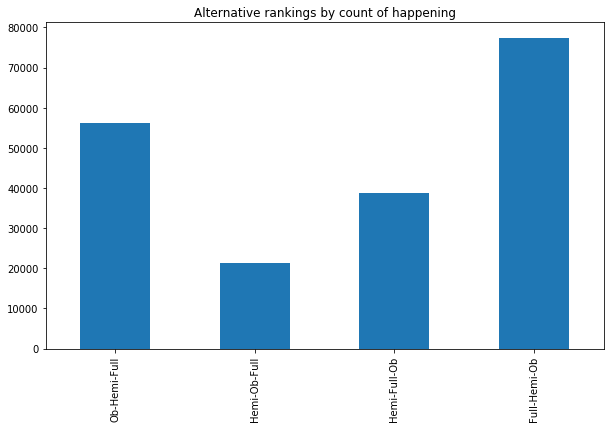

In [298]:
rankCounts.plot.bar()
plt.title("Alternative rankings by count of happening")
plt.show()

In [300]:
random.choice([1,3,4,5])

1

## Monte Carlo analysis

In [319]:
# Setup our comparisonSet that will allow us to loop over all possible
# comparisons for our ahp model
compareSet=ComparisonSet("Group", ahp, cmps)
mc = compareSet.monte_carlo(10000)

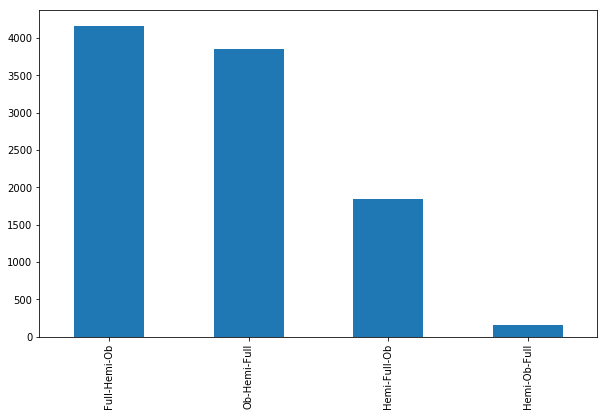

In [320]:
mc.plot.bar()